## Tratamento dos dados

#### Importação das bibliotecas

In [94]:
import pandas as pd
import os
from graph_tool import Graph, stats, spectral,centrality
import statsmodels.formula.api as smf

from netpixi.data.gt import *
import netpixi
import cpnet
import seaborn as sns
from math import sqrt
from matplotlib import rcParams
import statsmodels.formula.api as smf
import numpy as np
from scipy.stats import norm
import difflib
import seaborn as sns
from matplotlib import rcParams

#### Ligas disponíveis

O dataset de transferências possui os dados das seguintes ligas:

#### Problemas:

- Sub21 e Sub18
DATA_DIR = './data/transfers_master/data'- Incoerência entre as colunas club_name e club_involved_name

In [2]:
DATA_DIR = './data/transfers_master/data'
os.listdir(DATA_DIR + '/' + '2014')

['spanish_primera_division.csv',
 'dutch_eredivisie.csv',
 'portugese_liga_nos.csv',
 'french_ligue_1.csv',
 'italian_serie_a.csv',
 'russian_premier_liga.csv',
 'english_premier_league.csv',
 'english_championship.csv',
 'german_bundesliga_1.csv']

#### Loading Data

Função para carregar o dataset. Recebe o diretório que o data está salvo e o ano.

In [3]:
def loading_data(DATA_DIR, year):
    
    # Leitura do primeiro dataset para carregar as columns
    primeiro = 0
    # Loop desconsidera o primeiro elemento (carregado no código acima)
    for league in os.listdir(DATA_DIR + '/' + year)[0:]:
            string = (DATA_DIR + '/' + year + '/' + league)
            data_temp = pd.read_csv(string)
            if primeiro == 0:
                data = data_temp
                primeiro = 1
            else:
                # Concatenação dos dados
                data = pd.concat([data, data_temp])
     
    return(data)

def concat_year(start, end, DATA_DIR, data):
    
    for year in range(start, end+1):
        data = pd.concat([data, loading_data(DATA_DIR, str(year))])
        
    return data

In [4]:
DATA_DIR = './data/transfers_master/data'
YEAR = '1992'

data = loading_data(DATA_DIR, YEAR)
# data

In [5]:
data = concat_year(1993, 2015, DATA_DIR, data)

In [6]:
data[data['league_name']=='Serie A']

,club_name,player_name,age,position,club_involved_name,fee,transfer_movement,transfer_period,fee_cleaned,league_name,year,season
0,Milan AC,Jean-Pierre Papin,28.0,Centre-Forward,Marseille,£10.80m,in,Summer,10.80,Serie A,1992,1992/1993
1,Milan AC,Gianluigi Lentini,23.0,Right Winger,Torino,£8.60m,in,Summer,8.60,Serie A,1992,1992/1993
2,Milan AC,Dejan Savicevic,25.0,Attacking Midfield,Red Star,£4.14m,in,Summer,4.14,Serie A,1992,1992/1993
3,Milan AC,Guido Bistazzoni,32.0,Goalkeeper,Taranto,?,in,Summer,NaN,Serie A,1992,1992/1993
4,Milan AC,Fernando De Napoli,28.0,Central Midfield,SSC Napoli,?,in,Summer,NaN,Serie A,1992,1992/1993
...,...,...,...,...,...,...,...,...,...,...,...,...
1394,Frosinone Calcio,Arlind Ajeti,22.0,Centre-Back,Without Club,-,in,Winter,0.00,Serie A,2015,2015/2016
1395,Frosinone Calcio,Modibo Diakité,28.0,Centre-Back,Sampdoria,Free transfer,out,Winter,0.00,Serie A,2015,2015/2016
1396,Frosinone Calcio,Alessio Proietti,19.0,Right-Back,Isola Liri,Free transfer,out,Winter,0.00,Serie A,2015,2015/2016
1397,Frosinone Calcio,Giuliano Regolanti,21.0,Centre-Forward,Prato,Loan,out,Winter,0.00,Serie A,2015,2015/2016


In [7]:
data_in = data.loc[data["transfer_movement"] == "in"]
data_out = data.loc[data["transfer_movement"] == "out"]
data_in = data_in.reset_index()
data_out = data_out.reset_index()

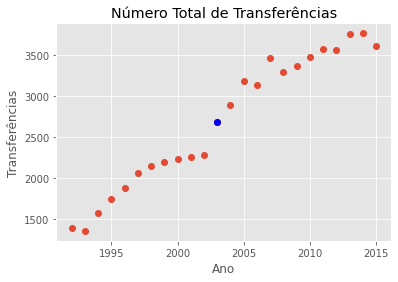

In [8]:
import matplotlib.pyplot as plt

pl = data_in["year"].value_counts()
pre_gal = pl.sort_index()
pos_gal = pl.sort_index()
pre_gal = pre_gal[:11]
pos_gal = pos_gal[11:]

plt.style.use('ggplot')
plt.title("Número Total de Transferências")
plt.xlabel("Ano")
plt.ylabel("Transferências")
plt.plot(pl.sort_index(), 'o', label = "Transferências")
plt.plot(2003 ,pl[2003], 'bo', label = "Era");

## Pré-Galácticos e Pós-Galacticos

O gráfico acima mostra a evolução no número de transferências de jogadores ao longo dos anos, dessa forma pode-se perceber que 2003 foi o ano em que houve a maior evolução no número de movimentações no mercado do futebol europeu da história. Portanto, deixou-se essa data como destaque em azul no gráfico, marcando o fim da era dos galácticos e o começo da era pós galácticos.

Assim, como o segundo gráfico mostra os anos em rosa que indicam a era pré-galácticos e os em azul a era pós-galácticos. 

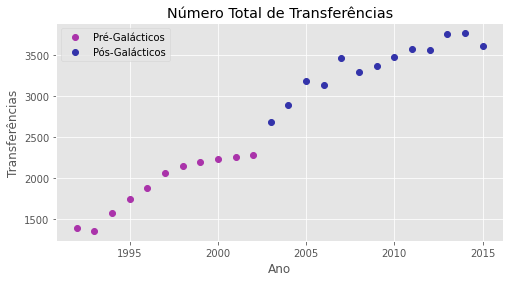

In [9]:
plt.figure(figsize = (8,4))
plt.plot(pre_gal, 'o', label = "Pré-Galácticos", color = "#AA33AA")
plt.plot(pos_gal, 'o', label = "Pós-Galácticos", color = "#3333AA")
plt.title("Número Total de Transferências")
plt.xlabel("Ano")
plt.ylabel("Transferências")
plt.legend(loc="upper left")
plt.show()

In [10]:
in_names = list(data_in["club_name"].value_counts().index)
out_names = list(data_in["club_involved_name"].value_counts().index)
name_dic = {}
problems = ["Olympique Marseille", "Olympique Lyon", "Eintracht Braunschweig", "Eintracht Frankfurt"]
for in_str in in_names:
    for out_str in out_names:

        if out_str[:10] in in_str and out_str != in_str:
            if (out_str not in problems) or (in_str not in problems):
#                 print(in_str ,", ", out_str)
                name_dic[out_str] = in_str

In [11]:
for k,v in name_dic.items():
    data_in["club_involved_name"].replace({k: v}, inplace=True)
    
# data_in

In [12]:
data_pre_gal = data_in[data_in["year"] <= 2003]
data_pos_gal =  data_in[data_in["year"] > 2003]

In [13]:
rede_normal = Graph(directed=True) # dirigido
rede_normal.vp['name'] = rede_normal.new_vp('object')
rede_normal.vp['league'] = rede_normal.new_vp('object')
rede_normal.ep["transfer"] = rede_normal.new_ep('object')

In [14]:
times = []
for index, rows in data_pos_gal.iterrows():
    time1 = rows[1]
    time2 = rows[5]
    if time1 not in times:
        times.append(time1)
        rede_normal.add_vertex()
        v_time = rede_normal.vertex(times.index(time1))
        rede_normal.vp['name'][v_time] = time1
        rede_normal.vp['league'][v_time] = rows[10]
        
    if time2 not in times:
        times.append(time2)
        rede_normal.add_vertex()
        v_time = rede_normal.vertex(times.index(time2))
        rede_normal.vp['name'][v_time] = time2
        rede_normal.vp['league'][v_time] = rows[10]
    
    index1 = times.index(time1)
    index2 = times.index(time2)
    
    if rede_normal.edge(index1, index2) == None:
        rede_normal.add_edge(index1, index2)
        e = rede_normal.edge(index1, index2)
        rede_normal.ep["transfer"][e] = 1
    else:
        e = rede_normal.edge(index1, index2)
        rede_normal.ep["transfer"][e] = rede_normal.ep["transfer"][e] + 1

In [15]:
data_in["league_name"].value_counts()

Championship        12342
Premier League       9652
Serie A              7532
Liga Nos             7382
Ligue 1              6365
Primera Division     5988
Eredivisie           5608
1 Bundesliga         5163
Premier Liga         4923
Name: league_name, dtype: int64

In [16]:
data_in[data_in['league_name']=='Serie A'][0:50]

,index,club_name,player_name,age,position,club_involved_name,fee,transfer_movement,transfer_period,fee_cleaned,league_name,year,season
561,0,Milan AC,Jean-Pierre Papin,28.0,Centre-Forward,Olympique Marseille,£10.80m,in,Summer,10.800,Serie A,1992,1992/1993
562,1,Milan AC,Gianluigi Lentini,23.0,Right Winger,Torino Calcio,£8.60m,in,Summer,8.600,Serie A,1992,1992/1993
563,2,Milan AC,Dejan Savicevic,25.0,Attacking Midfield,Red Star,£4.14m,in,Summer,4.140,Serie A,1992,1992/1993
564,3,Milan AC,Guido Bistazzoni,32.0,Goalkeeper,Taranto,?,in,Summer,NaN,Serie A,1992,1992/1993
565,4,Milan AC,Fernando De Napoli,28.0,Central Midfield,SSC Napoli,?,in,Summer,NaN,Serie A,1992,1992/1993
566,5,Milan AC,Davide Dionigi,18.0,Centre-Forward,Modena FC,?,in,Summer,NaN,Serie A,1992,1992/1993
567,6,Milan AC,Stefano Eranio,25.0,Right Midfield,Genoa 1893,?,in,Summer,NaN,Serie A,1992,1992/1993
568,7,Milan AC,Martino Traversa,18.0,Right-Back,Bologna FC 1909,?,in,Summer,NaN,Serie A,1992,1992/1993
569,8,Milan AC,Giuseppe Cardone,18.0,Right-Back,Milan U19,-,in,Summer,0.000,Serie A,1992,1992/1993
570,9,Milan AC,Giuseppe Zappella,19.0,Right-Back,Milan U19,-,in,Summer,0.000,Serie A,1992,1992/1993


In [17]:
rede_normal.vp['color'] = rede_normal.new_vp('object')

for v in rede_normal.vertices():
    if rede_normal.vp['league'][v] == "Premier League":
        rede_normal.vp['color'][v] = 0x0000ff
        
    if rede_normal.vp['league'][v] == "Eredivisie":
        rede_normal.vp['color'][v] = 0x00ff00
        
    if rede_normal.vp['league'][v] == "Championship":
        rede_normal.vp['color'][v] = 0x0000f0
        
    if rede_normal.vp['league'][v] == "Serie A":
        rede_normal.vp['color'][v] = 0xff00ff
        
    if rede_normal.vp['league'][v] == "Liga Nos":
        rede_normal.vp['color'][v] = 0xff0000
        
    if rede_normal.vp['league'][v] == "Ligue 1":
        rede_normal.vp['color'][v] = 0xffff00
        
    if rede_normal.vp['league'][v] == "1 Bundesliga":
        rede_normal.vp['color'][v] = 0x1100ff
        
    if rede_normal.vp['league'][v] == "Premier Liga":
        rede_normal.vp['color'][v] = 0x00ffff
        
stats.remove_self_loops(rede_normal)
m = draw_gt.sfdp_layout(rede_normal)
move_gt(rede_normal, m)
save_gt(rede_normal, 'rede_normal.net.gz')
# r = netpixi.render('exemplo4.net.gz')

In [18]:
def centro_periferia(g, t):
    matrix = spectral.adjacency(g)
    if t == "core":
        algorithm = cpnet.LowRankCore()
    elif t == "coreness":
        algorithm = cpnet.MINRES()

    algorithm.detect(matrix)
    c = algorithm.get_coreness()

    g.vp[t] = g.new_vp('object')
    for i, coreness in c.items():
        v = g.vertex(i)
        g.vp[t][v] = float(coreness)

In [19]:
centro_periferia(rede_normal, "core")

In [20]:
df = pd.DataFrame({k: list(v) for k, v in rede_normal.vp.items()})
df.head()

,name,league,color,_x,_y,core
0,Atlético Madrid,Primera Division,NaN,-4.096491,6.329542,1.0
1,Celta de Vigo,Primera Division,NaN,-4.099717,6.328234,1.0
2,Boca Juniors,Primera Division,NaN,-4.088707,6.328961,1.0
3,Albacete Balompié,Primera Division,NaN,-4.105271,6.334002,0.0
4,RCD Mallorca,Primera Division,NaN,-4.097976,6.325489,1.0


In [21]:
df["league"].value_counts()

Liga Nos            557
Premier Liga        350
Championship        342
Serie A             324
Eredivisie          298
Ligue 1             260
Primera Division    254
Premier League      229
1 Bundesliga        216
Name: league, dtype: int64

In [22]:
def plot_cp(df):
    plt.figure(figsize=(16,8))
    plt.plot(df[df["league"] == "Eredivisie"]["_x"], df[df["league"] == "Eredivisie"]["_y"],
             'o', markersize=12, label = "Eredivisie", alpha=.5)
    plt.plot(df[df["league"] == "Liga Nos"]["_x"], df[df["league"] == "Liga Nos"]["_y"],
             'o', markersize=12, label = "Liga Nos", alpha=.5)
    plt.plot(df[df["league"] == "Premier Liga"]["_x"], df[df["league"] == "Premier Liga"]["_y"],
             'o', markersize=12, label = "Premier Liga", alpha=.5)
    plt.plot(df[df["league"] == "Championship"]["_x"], df[df["league"] == "Championship"]["_y"],
             'o', markersize=12, label = "Championship", alpha=.5)
    plt.plot(df[df["league"] == "Serie A"]["_x"], df[df["league"] == "Serie A"]["_y"],
             'o', markersize=12, label = "Serie A", alpha=.5)
    plt.plot(df[df["league"] == "Ligue 1"]["_x"], df[df["league"] == "Ligue 1"]["_y"],
             'o', markersize=12, label = "Ligue 1", alpha=.5)
    plt.plot(df[df["league"] == "Premier League"]["_x"], df[df["league"] == "Premier League"]["_y"],
             'o', markersize=12, label = "Premier League", alpha=.5)
    plt.plot(df[df["league"] == "1 Bundesliga"]["_x"], df[df["league"] == "1 Bundesliga"]["_y"],
             'o', markersize=12, label = "1 Bundesliga", alpha=.5)
    plt.title("Classificação core & liga")
    plt.xlabel("posição em X")
    plt.ylabel("posição em Y")
    plt.legend(loc = "upper right")
    plt.show()

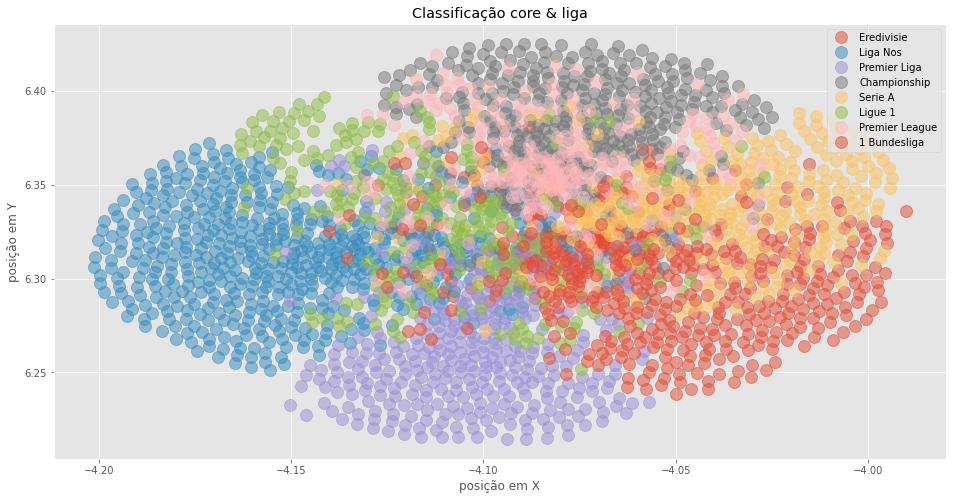

In [23]:
plot_cp(df)

## Conclusão sobre o grafo das tranferências entre clubes europeus

Observando o grafo plotado, é possível observar panelinhas entre as ligas do futebol europeu, fica bem claro a concentração entre os times de mesma liga quando se olha para as cores e os devidos posicionamentos dos vértices ao longo da rede, assim fica mais evidente a possível existência de times que interligam tranferências entre as ligas, os quais corroboram para a hipótese do grupo.

**Hipótese: Times com boa relação com times de diferentes ligas (relacionamento interliga) atingem melhor desempenho na champions league**


In [24]:
def loading_champions_data(DATA_DIR, year, end):
    list_df = []
    str_year = f"{year}-{str(year+1)[-2:]}"
    dir = "./data/champions_league/"+ str_year + "/champs.csv"
    data = pd.read_csv(dir)
    list_df.append(data)
    start = year + 1
    
    for year in range(start, end+1):
        str_year = f"{year}-{str(year+1)[-2:]}"
        dir = "./data/champions_league/"+ str_year + "/champs.csv"
        
        #data = pd.concat([data, pd.read_csv(dir)])
        data = pd.read_csv(dir)
        list_df.append(data)
    return(list_df)

In [25]:
DATA_DIR = './data/champions_league'
YEAR = 1993

list_df = loading_champions_data(DATA_DIR, YEAR, 2015)
list_df[1]


,Stage,Round,Group,Date,Team 1,FT,HT,Team 2,∑FT,ET,P,Comments
0,Qualifying,Prelim. Round | Leg 1,NaN,(Wed) 10 Aug 1994 (W32),AEK Athens › GRE (1),2-0,0-0,Rangers FC › SCO (1),NaN,NaN,NaN,NaN
1,Qualifying,Prelim. Round | Leg 1,NaN,(Wed) 10 Aug 1994 (W32),Avenir Beggen › LUX (1),1-5,0-0,Galatasaray İstanbul AŞ › TUR (1),NaN,NaN,NaN,NaN
2,Qualifying,Prelim. Round | Leg 1,NaN,(Wed) 10 Aug 1994 (W32),Silkeborg IF › DEN (1),0-0,0-0,Dinamo Kiev › UKR (1),NaN,NaN,NaN,NaN
3,Qualifying,Prelim. Round | Leg 1,NaN,(Wed) 10 Aug 1994 (W32),Paris Saint-Germain › FRA (1),3-0,0-0,Dunakanyar-Vac › HUN (1),NaN,NaN,NaN,NaN
4,Qualifying,Prelim. Round | Leg 1,NaN,(Wed) 10 Aug 1994 (W32),Legia Warsaw › POL (1),0-1,0-0,Hajduk Split › CRO (1),NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
72,Knockout,Semifinals | Leg 1,NaN,(Wed) 5 Apr 1995 (W14),Paris Saint-Germain › FRA (11),0-1,0-0,AC Milan › ITA (9),NaN,NaN,NaN,NaN
73,Knockout,Semifinals | Leg 1,NaN,(Wed) 5 Apr 1995 (W14),Bayern München › GER (9),0-0,0-0,AFC Ajax › NED (9),NaN,NaN,NaN,NaN
74,Knockout,Semifinals | Leg 2,NaN,(Wed) 19 Apr 1995 (W16),AFC Ajax › NED (10),5-2,3-1,Bayern München › GER (10),5-2 (agg.),NaN,NaN,NaN
75,Knockout,Semifinals | Leg 2,NaN,(Wed) 19 Apr 1995 (W16),AC Milan › ITA (10),2-0,1-0,Paris Saint-Germain › FRA (12),3-0 (agg.),NaN,NaN,NaN


In [26]:
def calcula_pontos(stage,round_,time1,time2,time1_placar,time2_placar,comentarios,dict_teams):
    pontos_ = 0
    if stage == 'Qualifying':
        pontos_=1
    elif stage == 'Group':
        pontos_=3
    else:
        pontos_ = 5
    if round_ == 'Final':
        pontos_ = 10
    
    
    if time1 not in dict_teams:
        dict_teams[time1] = 0
        
    if time2 not in dict_teams:
        dict_teams[time2] = 0
        
    if comentarios !=0:
        if comentarios == 1:
            time_vencedor = time1
        if comentarios == 2:
            time_vencedor = time2
    
    if time1_placar > time2_placar:
        time_vencedor = time1
    else:
        time_vencedor = time2
    dict_teams[time_vencedor] +=pontos_


In [27]:
dict_teams = {}
for i in range(len(list_df)):
    list_df[i]['Team 1'] = list_df[i]['Team 1'].str.split(' ›').str[0]
    list_df[i]['Team 2'] = list_df[i]['Team 2'].str.split(' ›').str[0]
    #list_df[i] = list_df[i].dropna(subset=['∑FT'])
    # limpando '∑FT'
    list_df[i]['∑FT'] = list_df[i]['∑FT'].str.replace("(","")
    list_df[i]['∑FT'] = list_df[i]['∑FT'].str.replace(")","")
    list_df[i]['∑FT'] = list_df[i]['∑FT'].str.replace("a ","")
    list_df[i]['∑FT'] = list_df[i]['∑FT'].str.replace("agg.","")
    list_df[i]['∑FT'] = list_df[i]['∑FT'].str.replace(" ","")
    list_df[i]['time1_placar_agregado'] = list_df[i]['∑FT'].str.split('-').str[0]
    list_df[i]['time2_placar_agregado'] = list_df[i]['∑FT'].str.split('-').str[1]
    # limpando P
    list_df[i]['P'] = list_df[i]['P'].astype(str).str.replace('(','')
    list_df[i]['P'] = list_df[i]['P'].astype(str).str.replace(")","", regex=True)
    list_df[i]['P'] = list_df[i]['P'].astype(str).str.replace("pen.","", regex=True)
    list_df[i]['time1_penalti'] = list_df[i]['P'].str.split('-').str[0]
    list_df[i]['time2_penalti'] = list_df[i]['P'].str.split('-').str[1]
    
    # limpando Comments (Away Goals)
    list_df[i]['Comments'] = list_df[i]['Comments'].str.replace('(','')
    list_df[i]['Comments'] = list_df[i]['Comments'].str.replace(')','')
    list_df[i]['Comments'] = list_df[i]['Comments'].str.replace('Away Goals ','')
    
    list_df[i]['time1_placar'] = list_df[i]['FT'].str.split('-').str[0]
    list_df[i]['time1_placar'] = list_df[i]['time1_placar'].str.replace(' ','')
    list_df[i]['time2_placar'] = list_df[i]['FT'].str.split('-').str[1]
    list_df[i] = list_df[i].drop(list_df[i][((list_df[i]['Stage'] == 'Knockout') & (list_df[i]['∑FT'].isnull()) & (list_df[i]['Round'] != 'Final'))].index)

    
    for index, rows in list_df[i].iterrows():
        stage = rows[0]
        round_ = rows[1]
        time1 = rows[4]
        time2 = rows[7]
        comments = rows[11]
        time1_placar_agregado = rows[12]
        time2_placar_agregado = rows[13]
        time1_penalti = rows[14]
        time2_penalti = rows[15]
        time1_placar = rows[16]
        time2_placar = rows[17]
        # checar se houve penalti
        if time1_penalti != 'nan':
            calcula_pontos(stage, round_,time1,time2,int(time1_penalti),int(time2_penalti),0, dict_teams)  
        # checar se teve gol fora de casa 
        elif comments == '1' or comments =='2':
            calcula_pontos(stage, round_,time1,time2,0,0,int(comments),dict_teams)
        # ver se é um jogo com placar agregado
        elif  type(time1_placar_agregado) == str:
            pass
            calcula_pontos(stage, round_,time1,time2,int(time1_placar_agregado),int(time2_placar_agregado),0,dict_teams)
        # passar o placar comum
        else:
            #print(time1_placar[0])
            calcula_pontos(stage, round_,time1,time2,int(time1_placar[0]),int(time2_placar[0]),0,dict_teams)

In [28]:
{k: v for k, v in sorted(dict_teams.items(), key=lambda item: item[1])}


{'Avenir Beggen': 0,
 'B68 Toftir': 0,
 'FK Partizani Tirana': 0,
 'Kispesti Honved': 0,
 'Silkeborg IF': 0,
 'Dunakanyar-Vac': 0,
 'Servette Geneve': 0,
 'Alania Vladikavkaz': 0,
 'FK Kareda Kaunas': 0,
 'Derry City': 0,
 'Lantana Tallinn': 0,
 'FC Tiraspol': 0,
 'GI Gota': 0,
 'Jeunesse Esch': 0,
 'Cliftonville': 0,
 'FK Vllaznia': 0,
 'FC Yerevan': 0,
 'Flora Tallinn': 0,
 'Kapaz': 0,
 'FC Metz': 0,
 'Araks Ararat': 0,
 'Glentoran': 0,
 'Dnepr Mogilev': 0,
 'Rapid Bucuresti': 0,
 'HNK Rijeka': 0,
 'Teplice': 0,
 'KI Klaksvik': 0,
 'NK Brotnjo': 0,
 'Shamkir': 0,
 'SSW Innsbruck': 0,
 'St. Gallen': 0,
 'HB Koge': 0,
 'TSV 1860 Munchen': 0,
 'Vagur': 0,
 'Lugano': 0,
 'Portadown': 0,
 'NK Zagreb': 0,
 'Hammarby': 0,
 'Lillestrom': 0,
 'Grevenmacher': 0,
 'FK Pobeda': 0,
 'Gomel': 0,
 'Rhyl': 0,
 'PFC Lokomotiv Plovdiv': 0,
 'Banik Ostrava': 0,
 'Everton FC': 0,
 'TVMK': 0,
 'Apollon Limassol': 0,
 'Shakhtyor Soligorsk': 0,
 'AC Chievo Verona': 0,
 'Metalurgi Rustavi': 0,
 'Murata': 0,

In [29]:
#para tirar
list_names_to_remove=[
    'Olimpija Ljubljana','Cwmbran Town','Avenir Beggen',
    'Linfield','FC Norma Tallinn','IA Akranes','AIK Solna','Kispesti Honved',
    'Dunakanyar-Vac','Barry Town','FK Sileks','Crusaders','Lantana Tallinn','FC Jazz',
    'FC Tiraspol','FC Slavia Mozyr','GI Gota','Kosice','Jeunesse Esch','Valletta',
    'B36 Torshavn','FK Vllaznia','FC Yerevan','FK Obilic','IB Vestmannaeyja','Flora Tallinn',
    'KF Tirana','Araks Ararat','Haka Valkeakoski','Dnepr Mogilev','Birkirkara','KR Reykjavik',
    'KI Klaksvik','Crvena Zvezda','NK Brotnjo','Zalgiris Vilnius','The New Saints',
    'Shamkir','Dunaujvaros','Belshina Bobruisk','Dinamo Tirana','Tampere United','FK Leotar',
    'NK Siroki Brijeg','HNK Gorica','PAOK FC','Sioni Bolnisi','FK Modrica','FC Santa Coloma',
    'Drogheda United','FK Mogren','UE Sant Julia','EB / Streymur''Stabaek','Fola Esch','Nomme Kalju'   
]

dict_teams_change={
    'Kobenhavn':'FC Copenhagen',
    'AFC Ajax':'Ajax Amsterdam',
    'Beşiktaş İstanbul JK':'Besiktas',
    'Fenerbahçe İstanbul SK':'Fenerbahce',
    'MTK':'MTK Budapest',
    "St Patrick's Athletic":"St. Patricks",
    "Skonto":"Skonto Riga",
    "Juventus":"Juventus FC",
    "Internazionale":"Inter Milan",
    "FK Zalgiris Vilnius":"Zalgiris",
    "Lille OSC":"LOSC Lille",
    "Vardar Skopje":'Vardar',
    "Celta Vigo":"Celta de Vigo",
    "Kairat":"Kairat Almaty",
    "Dinamo Moskva":'Dinamo Moscow'

}
#count = 0
list_names = []
for name in list(dict_teams.keys()):
    if name not in list(df['name']):
        if name in list_names_to_remove:
            dict_teams.pop(name, None)
        elif name in dict_teams_change:
            dict_teams[dict_teams_change[name]] = dict_teams[name]
            dict_teams.pop(name,None)
        else:
            name_gerado=difflib.get_close_matches(name,list(df['name']),n=1,cutoff=0.5)
            if len(name_gerado)>0:
                dict_teams[name_gerado[0]] = dict_teams[name]
                dict_teams.pop(name,None)
            else:
                print(name)
                dict_teams.pop(name,None)

# # para substituir
# Kobenhavn[FC Copenhagen]
# AFC Ajax[Ajax Amsterdam]
# Beşiktaş İstanbul JK[Besiktas]
# Fenerbahçe İstanbul SK[Fenerbahce]
# MTK[MTK Budapest]
# St Patrick's Athletic[St. Patricks]
#Skonto[Skonto Riga]
#Juventus[Juventus FC]
#Internazionale[Inter Milan],
# FK Zalgiris Vilnius[Zalgiris]
#Lille OSC[LOSC Lille]
#Vardar Skopje[Vardar]
#Celta Vigo[Celta de Vigo]
#Kairat[Kairat Almaty]
#Dinamo Moskva[Dinamo Moscow]

Sloga Jugomagnat Skopje
SSW Innsbruck
FH
TVMK
NSI
Dnepr Dnepropetrovsk


In [30]:
len(dict_teams)

294

In [31]:
list(df['name'])[1151]

'Stoke U18'

In [32]:
from collections import Counter

a = dict(Counter(list_names))
for k,v in a.items():
    if v ==1:
        print(k,v)

In [33]:
difflib.get_close_matches("Ajax Amsterdam",list(df['name']),n=15,cutoff=0.6)

['Ajax Amsterdam', 'AFC Amsterdam', 'Ajax Amateurs']

In [34]:
len(dict_teams)

294

In [35]:
df[df['name'].str.contains("Vardar")]

,name,league,color,_x,_y,core
1525,Vardar,Liga Nos,16711680.0,-4.137014,6.269201,0.0


In [36]:
count =0
betweenness, _ = centrality.betweenness(rede_normal)
for v in betweenness:
    print(v)
    if v<0.00001:
        count +=1
print(count)

0.0009680585970190538
0.0004362698223752064
0.0
4.9242621623614624e-05
0.0006552344012013469
0.0005077477706164344
0.0027915274596365114
0.0013472202904908403
0.0
0.0010726881301653664
0.0006286481776799553
0.0
0.0013707513412627701
0.0
0.0
0.00011334288537755678
0.0003838141650571442
0.0
0.004111034486835226
0.0
0.0008443554009998881
5.251338066160609e-05
0.0
0.0007010617004361607
0.0
2.184050570120402e-05
0.00019759654079739541
0.0009862660508871495
0.0001002729911626841
9.369318961222344e-05
0.0
0.0007409380015154186
0.001503469350874283
0.0006071206623985165
0.0
0.0
0.0
0.0011034252973518915
0.0016228873275485486
0.000572296699836159
0.0
0.004495001245612314
0.0
0.00027043468827634543
0.00011930865843711775
0.0
0.00010437437695293597
0.0
0.0
0.0012219727170379344
0.0
0.0
0.0002558733823131403
0.0018549880826590872
0.0003701853689476973
0.00013987018906716815
3.873100289939397e-05
0.00045492915654879386
0.0005364096511627862
0.0
3.47860079385332e-05
0.00040999870032978035
0.0
0.0
0.

0.0
4.599485252584191e-05
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.000299133111860634
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.00010946990626221187
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.00027457579003927005
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0

In [37]:
rede_normal.vp['betweenness'] = betweenness

In [38]:
df = pd.DataFrame({k: list(v) for k, v in rede_normal.vp.items()})


In [39]:
df['pontos'] = 0

In [40]:
for name,pontos in dict_teams.items():
    df.loc[df['name'] == name,'pontos'] = pontos

In [41]:
df

,name,league,color,_x,_y,core,betweenness,pontos
0,Atlético Madrid,Primera Division,NaN,-4.096491,6.329542,1.0,0.000968,134
1,Celta de Vigo,Primera Division,NaN,-4.099717,6.328234,1.0,0.000436,11
2,Boca Juniors,Primera Division,NaN,-4.088707,6.328961,1.0,0.000000,0
3,Albacete Balompié,Primera Division,NaN,-4.105271,6.334002,0.0,0.000049,0
4,RCD Mallorca,Primera Division,NaN,-4.097976,6.325489,1.0,0.000655,16
...,...,...,...,...,...,...,...,...
2825,SC Fortuna Köln,1 Bundesliga,1114367.0,-4.108331,6.364559,0.0,0.000000,0
2826,Kyung Hee Univ.,1 Bundesliga,1114367.0,-4.073165,6.255959,0.0,0.000000,0
2827,Odds BK,1 Bundesliga,1114367.0,-4.038789,6.257356,0.0,0.000000,0
2828,FC Vysocina,1 Bundesliga,1114367.0,-4.051501,6.271112,0.0,0.000000,0


In [76]:
df[df['name'].str.contains("Lyon")]


,name,league,color,_x,_y,core,betweenness,pontos
85,Olympique Lyon,Primera Division,NaN,-4.094319,6.331796,1.0,0.000512,209
357,Olymp. Lyon B,Ligue 1,16776960.0,-4.120461,6.316189,0.0,0.000000,0
1003,Olymp. Lyon U19,Ligue 1,16776960.0,-4.075812,6.276668,0.0,0.000000,0


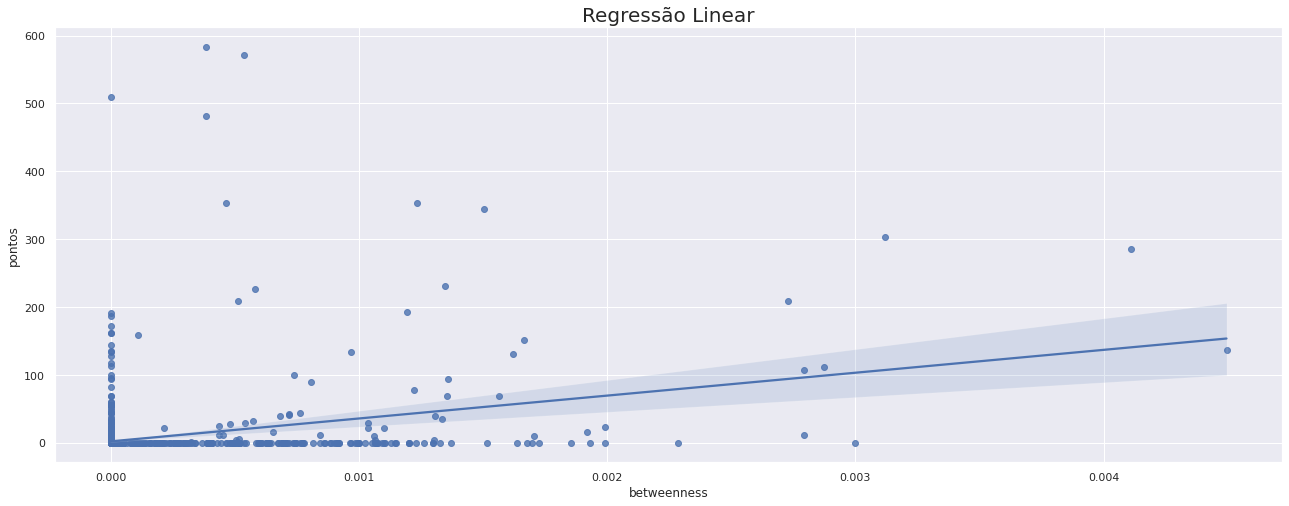

In [101]:
sns.set()

plt.figure(figsize=(22,8))
sns.regplot(x=df['betweenness'], y=df['pontos'])
plt.title("Regressão Linear", fontsize=20)
plt.show()

In [79]:
model = smf.ols(data=df, formula='pontos ~ betweenness')
result_with_zero = model.fit()
result_with_zero.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 pontos   R-squared:                       0.106
Model:                            OLS   Adj. R-squared:                  0.105
Method:                 Least Squares   F-statistic:                     334.5
Date:                Tue, 16 Nov 2021   Prob (F-statistic):           1.04e-70
Time:                        21:38:39   Log-Likelihood:                -13409.
No. Observations:                2830   AIC:                         2.682e+04
Df Residuals:                    2828   BIC:                         2.683e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       1.7086      0.532      3.211      0.001       0.665       2.752
betweenness  3.374e+04   1844.846     18.289      0.000    3.01e+04    3.74e+04
==============================================================================
Omnibus:                     5043.851   Durbin-Watson:                   2.029
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          5371642.698
Skew:                          12.671   Prob(JB):                         0.00
Kurtosis:                     214.925   Cond. No.                     3.55e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.55e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [80]:
def linear_resplot(result):
    width, height = rcParams['figure.figsize']
    fig, axs = plt.subplots(1, 2, figsize=(2 * width, height))
    ax = sns.scatterplot(x=result.fittedvalues, y=result.resid, ax=axs[0])
    ax.axhline(0)
    sns.histplot(result.resid, ax=axs[1])
    plt.show()

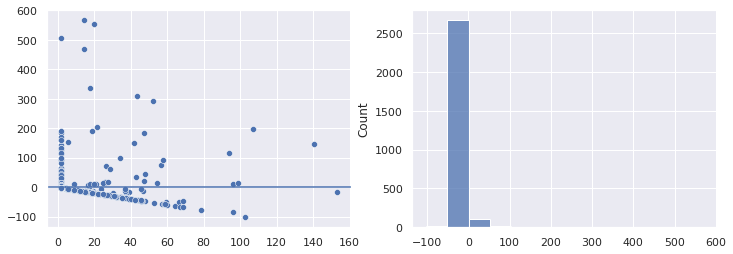

In [87]:
linear_resplot(result_with_zero)

In [102]:
df2 = df[(df['pontos'] > 0)]

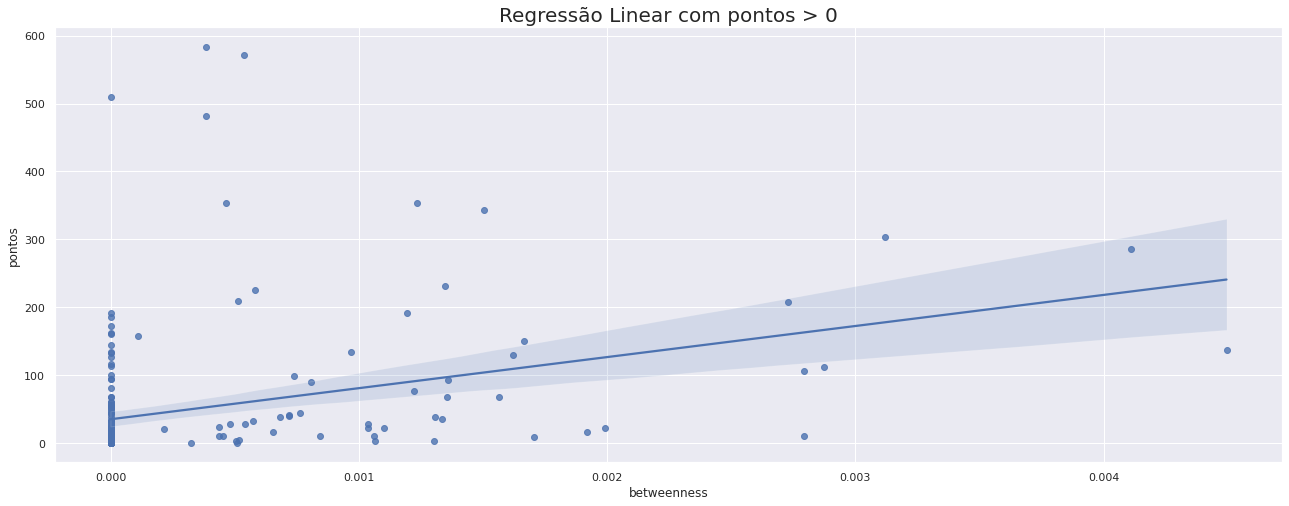

In [106]:
sns.set()
plt.figure(figsize=(22,8))
sns.regplot(x=df2['betweenness'], y=df2['pontos'])
plt.title("Regressão Linear com pontos > 0", fontsize=20)
plt.show()

In [107]:
model = smf.ols(data=df2, formula='pontos ~ betweenness') 
result_not_zero = model.fit()
result_not_zero.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 pontos   R-squared:                       0.118
Model:                            OLS   Adj. R-squared:                  0.113
Method:                 Least Squares   F-statistic:                     28.77
Date:                Tue, 16 Nov 2021   Prob (F-statistic):           2.09e-07
Time:                        21:58:13   Log-Likelihood:                -1286.3
No. Observations:                 218   AIC:                             2577.
Df Residuals:                     216   BIC:                             2583.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      35.2676      6.555      5.380      0.000      22.348      48.188
betweenness  4.576e+04   8530.600      5.364      0.000    2.89e+04    6.26e+04
==============================================================================
Omnibus:                      196.111   Durbin-Watson:                   1.889
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2830.996
Skew:                           3.628   Prob(JB):                         0.00
Kurtosis:                      19.094   Cond. No.                     1.42e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.42e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

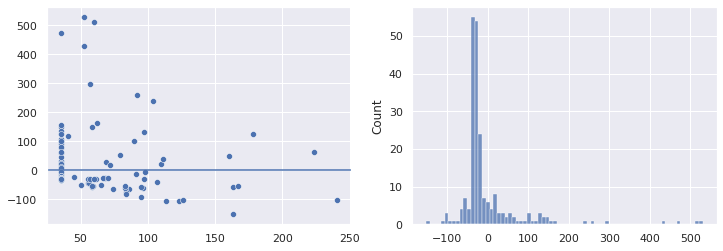

In [108]:
linear_resplot(result_not_zero)

In [114]:
df3 = df[(df['pontos'] >0) & (df['betweenness'] > 0.0000000001)]

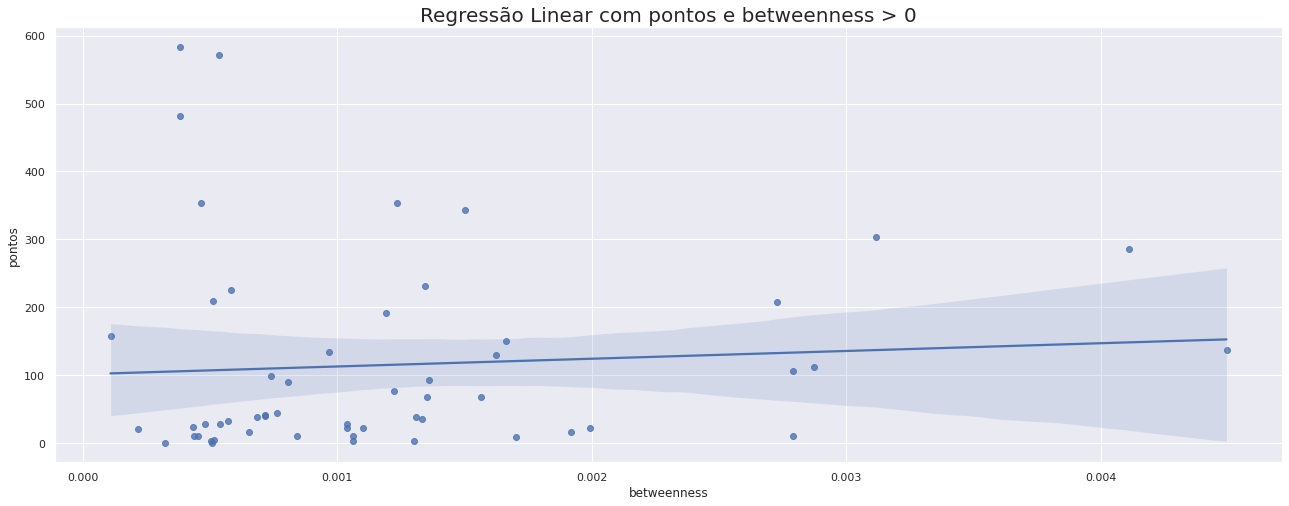

In [115]:
sns.set()
plt.figure(figsize=(22,8))
sns.regplot(x=df3['betweenness'], y=df3['pontos'])
plt.title("Regressão Linear com pontos e betweenness > 0", fontsize=20)
plt.show()

In [116]:
model = smf.ols(data=df3, formula='pontos ~ betweenness') 
result_not_zero_total = model.fit()
result_not_zero_total.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 pontos   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                 -0.013
Method:                 Least Squares   F-statistic:                    0.2960
Date:                Tue, 16 Nov 2021   Prob (F-statistic):              0.589
Time:                        22:05:12   Log-Likelihood:                -350.74
No. Observations:                  55   AIC:                             705.5
Df Residuals:                      53   BIC:                             709.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept     101.5419     32.084      3.165      0.003      37.190     165.893
betweenness  1.141e+04    2.1e+04      0.544      0.589   -3.07e+04    5.35e+04
==============================================================================
Omnibus:                       28.981   Durbin-Watson:                   2.110
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               48.938
Skew:                           1.823   Prob(JB):                     2.36e-11
Kurtosis:                       5.840   Cond. No.                     1.07e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.07e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

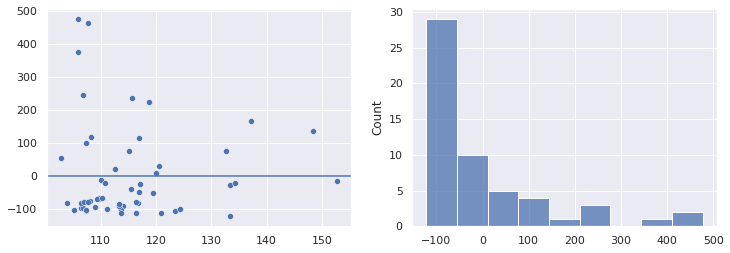

In [113]:
linear_resplot(result_not_zero_total)